# Beam Warming for a sinusoidal input

## Understand the problem

- We want to analyze the behavior of the Beam-Warming scheme compared to the behavior of the LeapFrog scheme given a sinusoidal input function inspired from the fact that errors always lag behind the solution for the LeapFrog scheme while those errors can either lead the solution or lag behind it in the Beam-Warming scheme. 

- The model linear convection equation is given by:

\begin{equation}
\frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0
\end{equation}

## Formulate the problem

### Input Data

- nt = 51 (number of temporal points)

- nx = 21 (number of spatial points)

- tmax = 0.5

- xmax = 4.0

- c = 1

    - Initial conditions: 
    
    - We require $N_p$ periods in 1m, i.e. a wavelength equals to $\lambda = 1/N_p$ and $k = \frac{2\pi}{\lambda} = 4\pi N_p$ and hence, at $t = 0$
 
    \begin{equation}
    u(x, t = 0) = sin(2\pi N_p x)
    \end{equation}
    
    - Boundary conditions: 
    \begin{equation}
    u(x = 0, t) = 0.0 \\ u(x = 4.0, t) = 0.0
    \end{equation}

### Output data

- We want to compute the solution $u(x,t)$ elsewhere.


### Numerical schemes

#### LeapFrog Scheme
\begin{equation}
\frac{u^{n+1}_{i} - u^{n-1}_{i}}{2\Delta t} + c \frac{u^{n}_{i+1} - u^{n}_{i-1}}{2\Delta x} = 0
\end{equation}

After transposition we get:
\begin{equation}
u^{n+1}_{i} = u^{n-1}_{i} - \sigma \left (u^{n}_{i+1} - u^{n}_{i-1}  \right )
\end{equation}
With:
\begin{equation}
\sigma = c \frac{\Delta t}{\Delta x}
\end{equation}

- This problem is of 3 levels in time, but to begin the simulation, we only need 2 time levels, and that is why we will begin the simulation with the Upwind scheme:

\begin{equation}
u^{n+1}_{i}  = u^{n}_{i} - \sigma (u^{n}_{i} - u^{n}_{i-1})
\end{equation}


#### Beam-Warming Scheme

- The Beam-Warming scheme after transposition reads:

\begin{equation}
u^{n+1}_{i} = u^{n}_{i} - \frac{\sigma}{2} \left (3u^{n}_{i} - 4u^{n}_{i-1} + u^{n}_{i-2}  \right ) + \frac{\sigma^2}{2} \left (u^{n}_{i} - 2u^{n}_{i-1} + u^{n}_{i-2}  \right )
\end{equation}

In [96]:
def analytical_convection(tmax, xmax, nx, nt, c, Np, CFL = 1.0, iteration = 0):
    
    import numpy as np
    
    dx = xmax/(nx-1)
    x = np.linspace(0.0, xmax, nx)
    dt = CFL*dx/c
    t = np.linspace(0.0, tmax, nt)
    u = np.zeros((nt, nx))
    
    for i in range(nx):
        if 0.0 <= x[i] - c*t[iteration] <= 1.0:
            xp = x[i] - c*t[iteration]
            u[iteration, i] = np.sin(2*np.pi*Np*xp)
        else:
            u[iteration, i] = 0.0
            
    return x, u

In [83]:
def Plotter(x, u, tmax, xmax, nx, c, CFL = 1.0, iteration = 0):
    
    import numpy as np
    import matplotlib.pyplot as plt

    dx = xmax/(nx-1)
    dt = CFL*dx/c
    nt = int((tmax/dt)+1)
    
    CFL = float(round(CFL, 3))
    
    t = iteration*dt
    t = float(round(t, 2))
    
    fig, ax = plt.subplots(figsize = [8.5, 5.8])
    
    ax.set_xlim(0.0, xmax)
    ax.set_xlabel("x(SI)")
    ax.set_ylabel("u(x,t = {:})".format(t))
    ax.plot(x, u[iteration, :], label = "Numerical Solution, CFL = {:}".format(CFL))
    
    ax.set_xlim(-1.0, xmax)
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()

nt = 84


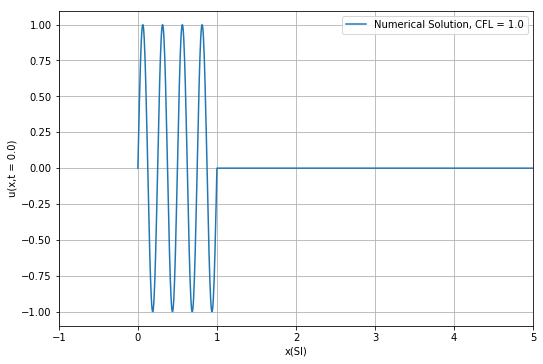

In [85]:
(tmax, xmax, nx, c, Np) = (0.5, 5.0, 1001, 1.0, 4)
x, u = analytical_convection(tmax, xmax, nx, c, Np)
print("nt =", nt)
Plotter(x, u, tmax, xmax, nx, c, iteration = 0)

In [86]:
def Initial_Boundary(tmax, xmax, nx, nt, c, Np, CFL = 1.0):
    
    import numpy as np
    dx = xmax/(nx-1)
    dt = CFL*dx/c

    x = np.linspace(0.0, xmax, nx)
    u = np.zeros((nt, nx))
    
    # IC:
    for i in range(nx-1):
        if 0.0 <= x[i] <= 1.0:
            u[0, i] = np.sin(2*np.pi*Np*x[i])
        else:
            u[0, i] = 0.0
    # BC:
    u[:, 0] = u[:, nx-1] = 0.0
    
    return x, u

In [87]:
def Convection_solver(tmax, xmax, nx, c, Np, CFL = 1.0):
    
    import numpy as np
    dx = xmax/(nx-1)
    dt = CFL*dx/c
    nt = int(1 + tmax/dt)
    
    x, u = Initial_Boundary(tmax, xmax, nx, nt, c, Np, CFL)
    
    choix = int(input("Entrez votre choix de schema:\n1- LeapFrog\n2- Beam-Warming\n\tVotre choix: "))
    if choix == 1:
        # LeapFrog:
        for n in range(nt-1):
            for i in range(1, nx-1):
                if n <= 1:
                    u[n+1, i] = u[n, i] - CFL*(u[n, i] - u[n, i-1])
                else:
                    u[n+1, i] = u[n-1, i] - CFL*(u[n, i+1] - u[n, i-1])
    elif choix == 2:        
        # Beam-Warming:
        for n in range(nt-1):
            for i in range(2, nx-1):
                u[n+1, i] = u[n, i] - (CFL/2)*(3*u[n,i] - 4*u[n, i-1] + u[n, i-2]) + ((CFL**2)/2)*(u[n,i] - 2*u[n, i-1] + u[n, i-2])

    else:
        raise ValueError("Out of bounds !! Retry !!")
    
    return nt, x, u

## A Plotter to compare analytical with numerical:

In [88]:
def Plotter_3(x, u, u_analytical, tmax, xmax, nx, c, CFL = 1.0, iteration = 0, limite = [0.0, xmax]):
    
    import numpy as np
    import matplotlib.pyplot as plt

    dx = xmax/(nx-1)
    dt = CFL*dx/c
    nt = int((tmax/dt)+1)
    
    t = float(round(iteration*dt, 2))
    
    fig, ax = plt.subplots(figsize = [8.5, 5.8])
    
    ax.set_xlabel("x(SI)")
    ax.set_ylabel("u(x,t = {:})".format(t))
    ax.plot(x, u[iteration, :], linestyle = "--", color = "red", linewidth = "2.5", label = "Numerical Solution a t = {:}".format(t))
    ax.plot(x, u_analytical[iteration, :], linestyle = ":", linewidth = "2.5", label = "Analytical Solution a t = {:}".format(t))

    ax.set_xlim(limite[0], limite[1])
    ax.set_title("CFL = {:}".format(CFL))
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()

Entrez votre choix de schema:
1- LeapFrog
2- Beam-Warming
	Votre choix: 1
nt = 143
Entrez l'iteration: 140


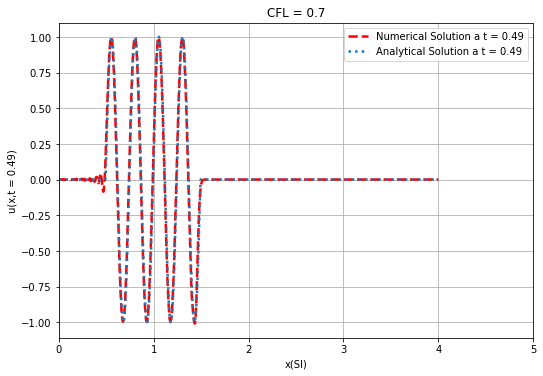

In [102]:
(tmax, xmax, nx, c, Np, CFL) = (0.5, 4.0, 801, 1.0, 4, 0.7)
nt, x, u = Convection_solver(tmax, xmax, nx, c, Np, CFL)
print("nt =", nt)
iteration = int(input("Entrez l'iteration: "))
x, u_analytical = analytical_convection(tmax, xmax, nx, nt, c, Np, CFL, iteration)
Plotter_3(x, u, u_analytical, tmax, xmax, nx, c, CFL, iteration) # , limite = [0.0, xmax]

Entrez votre choix de schema:
1- LeapFrog
2- Beam-Warming
	Votre choix: 2
nt = 143
Entrez l'iteration: 140


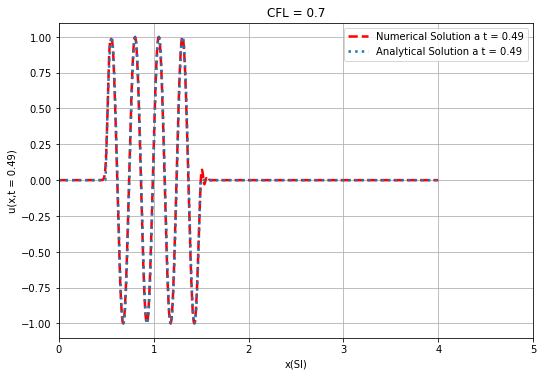

In [103]:
(tmax, xmax, nx, c, Np, CFL) = (0.5, 4.0, 801, 1.0, 4, 0.7)
nt, x, u = Convection_solver(tmax, xmax, nx, c, Np, CFL)
print("nt =", nt)
iteration = int(input("Entrez l'iteration: "))
x, u_analytical = analytical_convection(tmax, xmax, nx, nt, c, Np, CFL, iteration)
Plotter_3(x, u, u_analytical, tmax, xmax, nx, c, CFL, iteration) # , limite = [0.0, xmax]